In [1]:
# clone YOLOv5 repo
!git clone https://github.com/ultralytics/yolov5 # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17080, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 17080 (delta 21), reused 7 (delta 7), pack-reused 17050 (from 3)
Receiving objects: 100% (17080/17080), 15.69 MiB | 28.79 MiB/s, done.
Resolving deltas: 100% (11726/11726), done.
/content/yolov5


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output # for displaying images
from utils.downloads import attempt_download

# cleat_output()
print("Setup complete. Using torch %s %s" % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 26.7 MB/s eta 0:00:00
Setup complete. Using torch 2.5.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=ddcd5399-ce25-f945-f4df-a9b279881b6b, L2_cache_size=4MB)


In [3]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("sg-icrum").project("simtrafficview5k")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SimTrafficView5K-1 in yolov5pytorch:: 100%|██████████| 10012/10012 [00:01<00:00, 5090.90it/s]


In [5]:
%cd /content/yolov5

/content/yolov5


In [6]:
%pwd

'/content/yolov5'

In [7]:
dataset.location

'/content/yolov5/SimTrafficView5K-1'

In [8]:
# view the YAML file created by Roboflow
%cat {dataset.location}/data.yaml

names:
- '0'
- '1'
- '2'
- '3'
nc: 4
roboflow:
  license: CC BY 4.0
  project: simtrafficview5k
  url: https://universe.roboflow.com/sg-icrum/simtrafficview5k/dataset/1
  version: 1
  workspace: sg-icrum
test: ../test/images
train: SimTrafficView5K-1/train/images
val: SimTrafficView5K-1/valid/images


In [10]:
# define number of classes based on YAML file
import yaml
import os
with open(os.path.join(dataset.location, "data.yaml"), "r") as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

In [19]:
num_classes

'4'

In [11]:
# model configuration that will be used
%cat /content/yolov5/models/yolov5s.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

In [26]:
num_classes

'4'

In [27]:
# customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

In [28]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [29]:
# train yolov5s on custom data for 200 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      38/49         2G    0.01829     0.0214   0.002781        531        416:  76% 166/219 [00:34<00:14,  3.69it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      38/49         2G    0.01828    0.02142   0.002781        674        416:  76% 167/219 [00:34<00:13,  3.94it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      38/49         2G    0.01828    0.02141   0.002779        529        416:  77% 168/219 [00:34<00:13,  3.85it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(

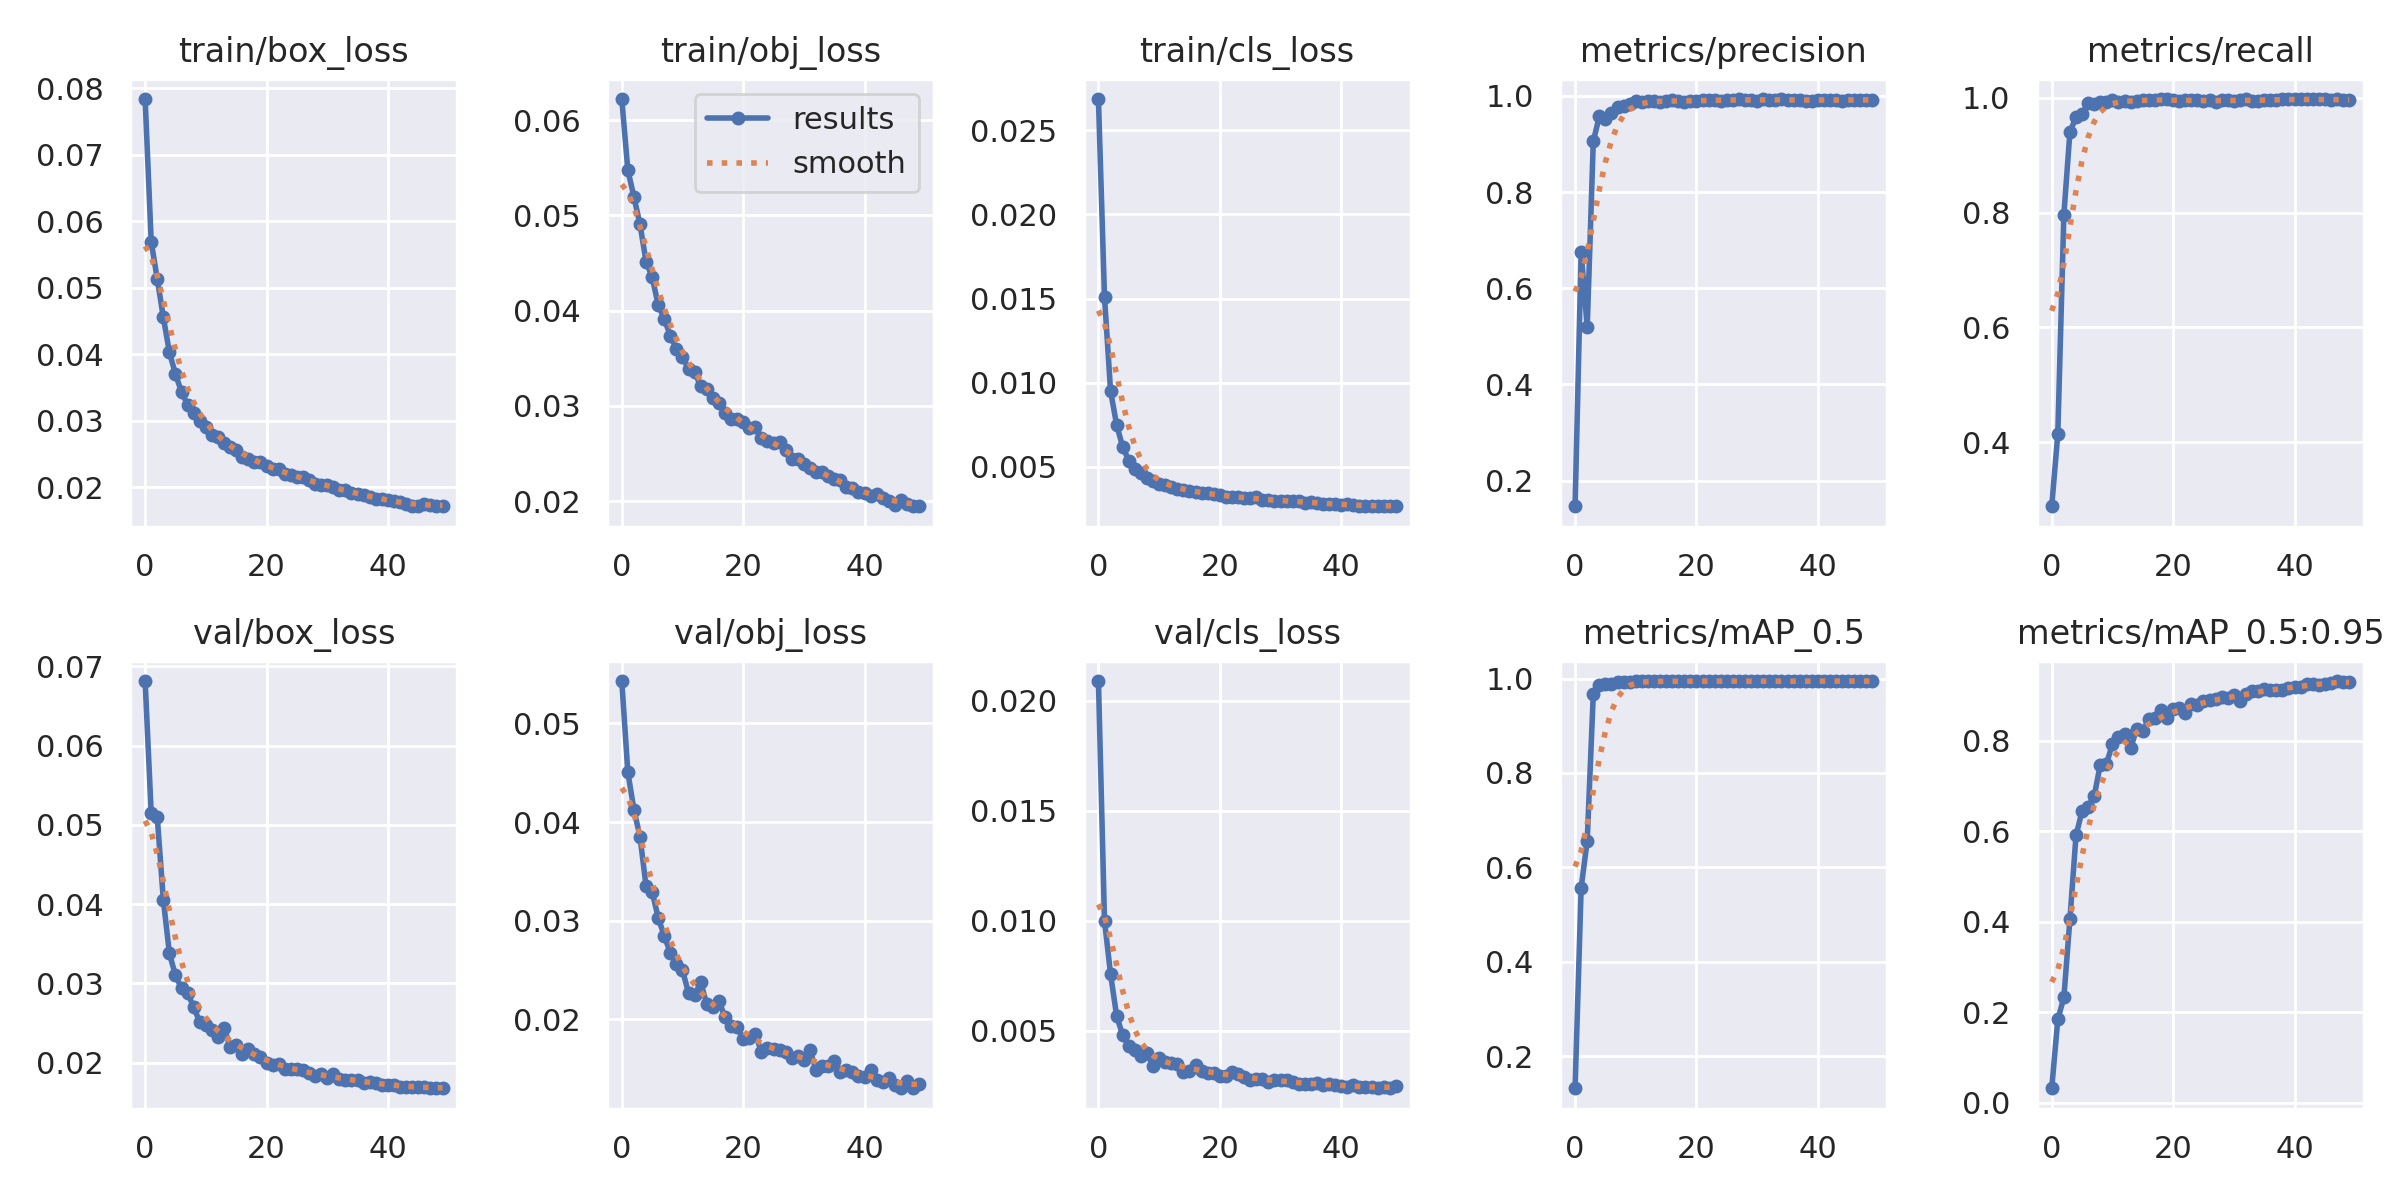

In [30]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

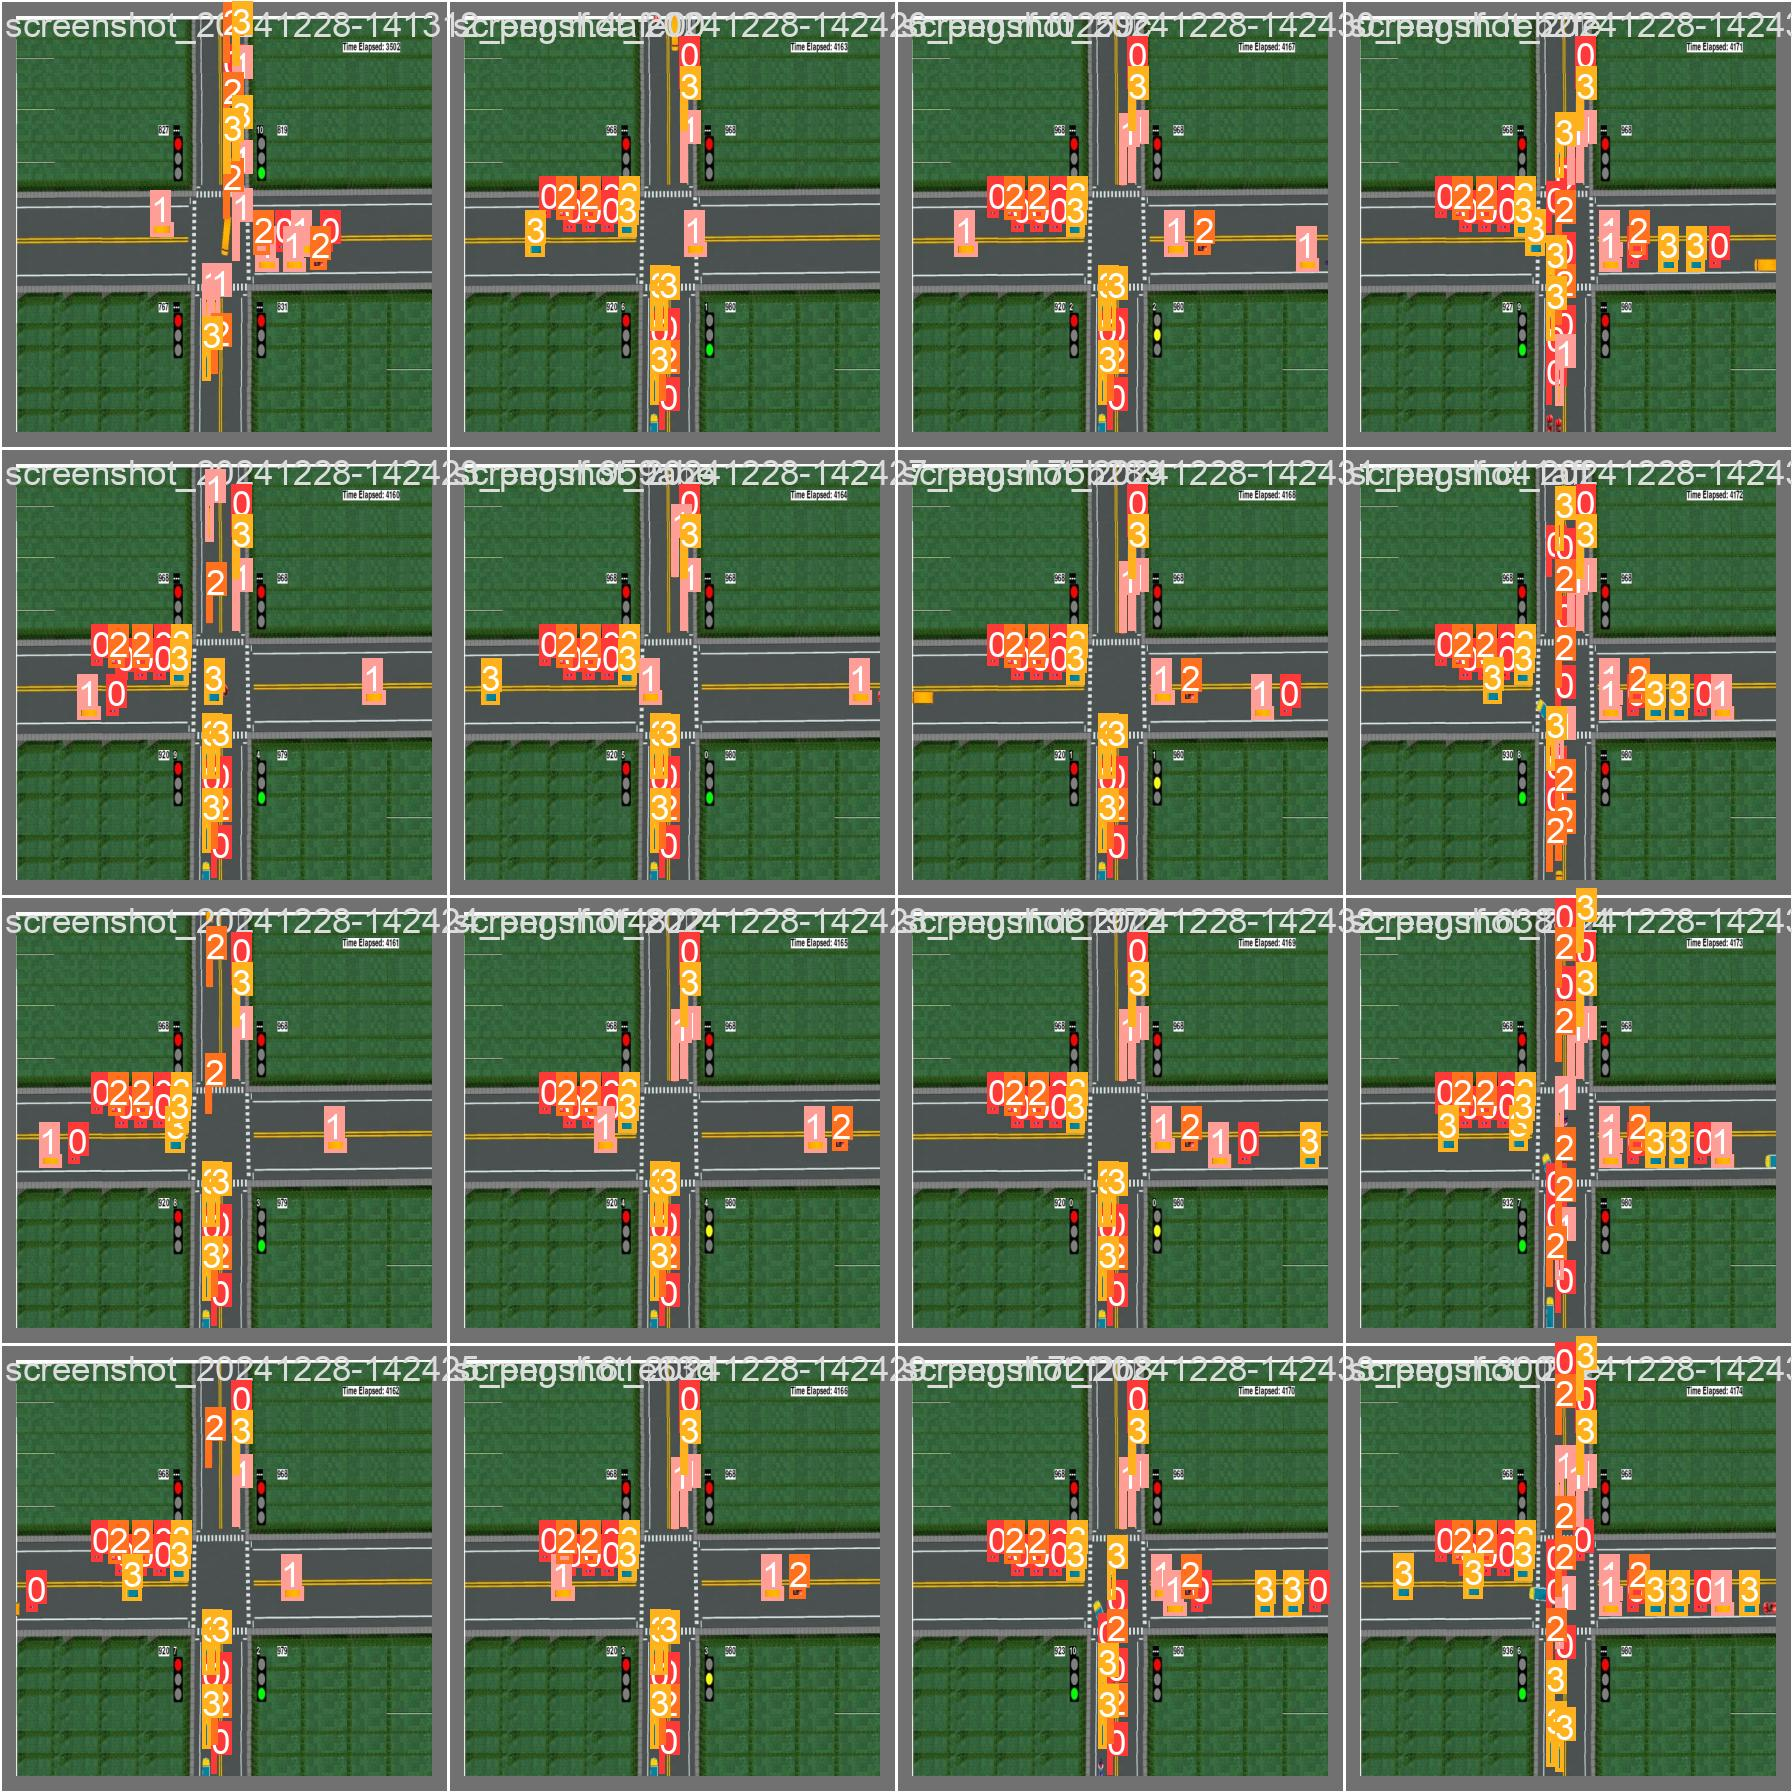

In [31]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


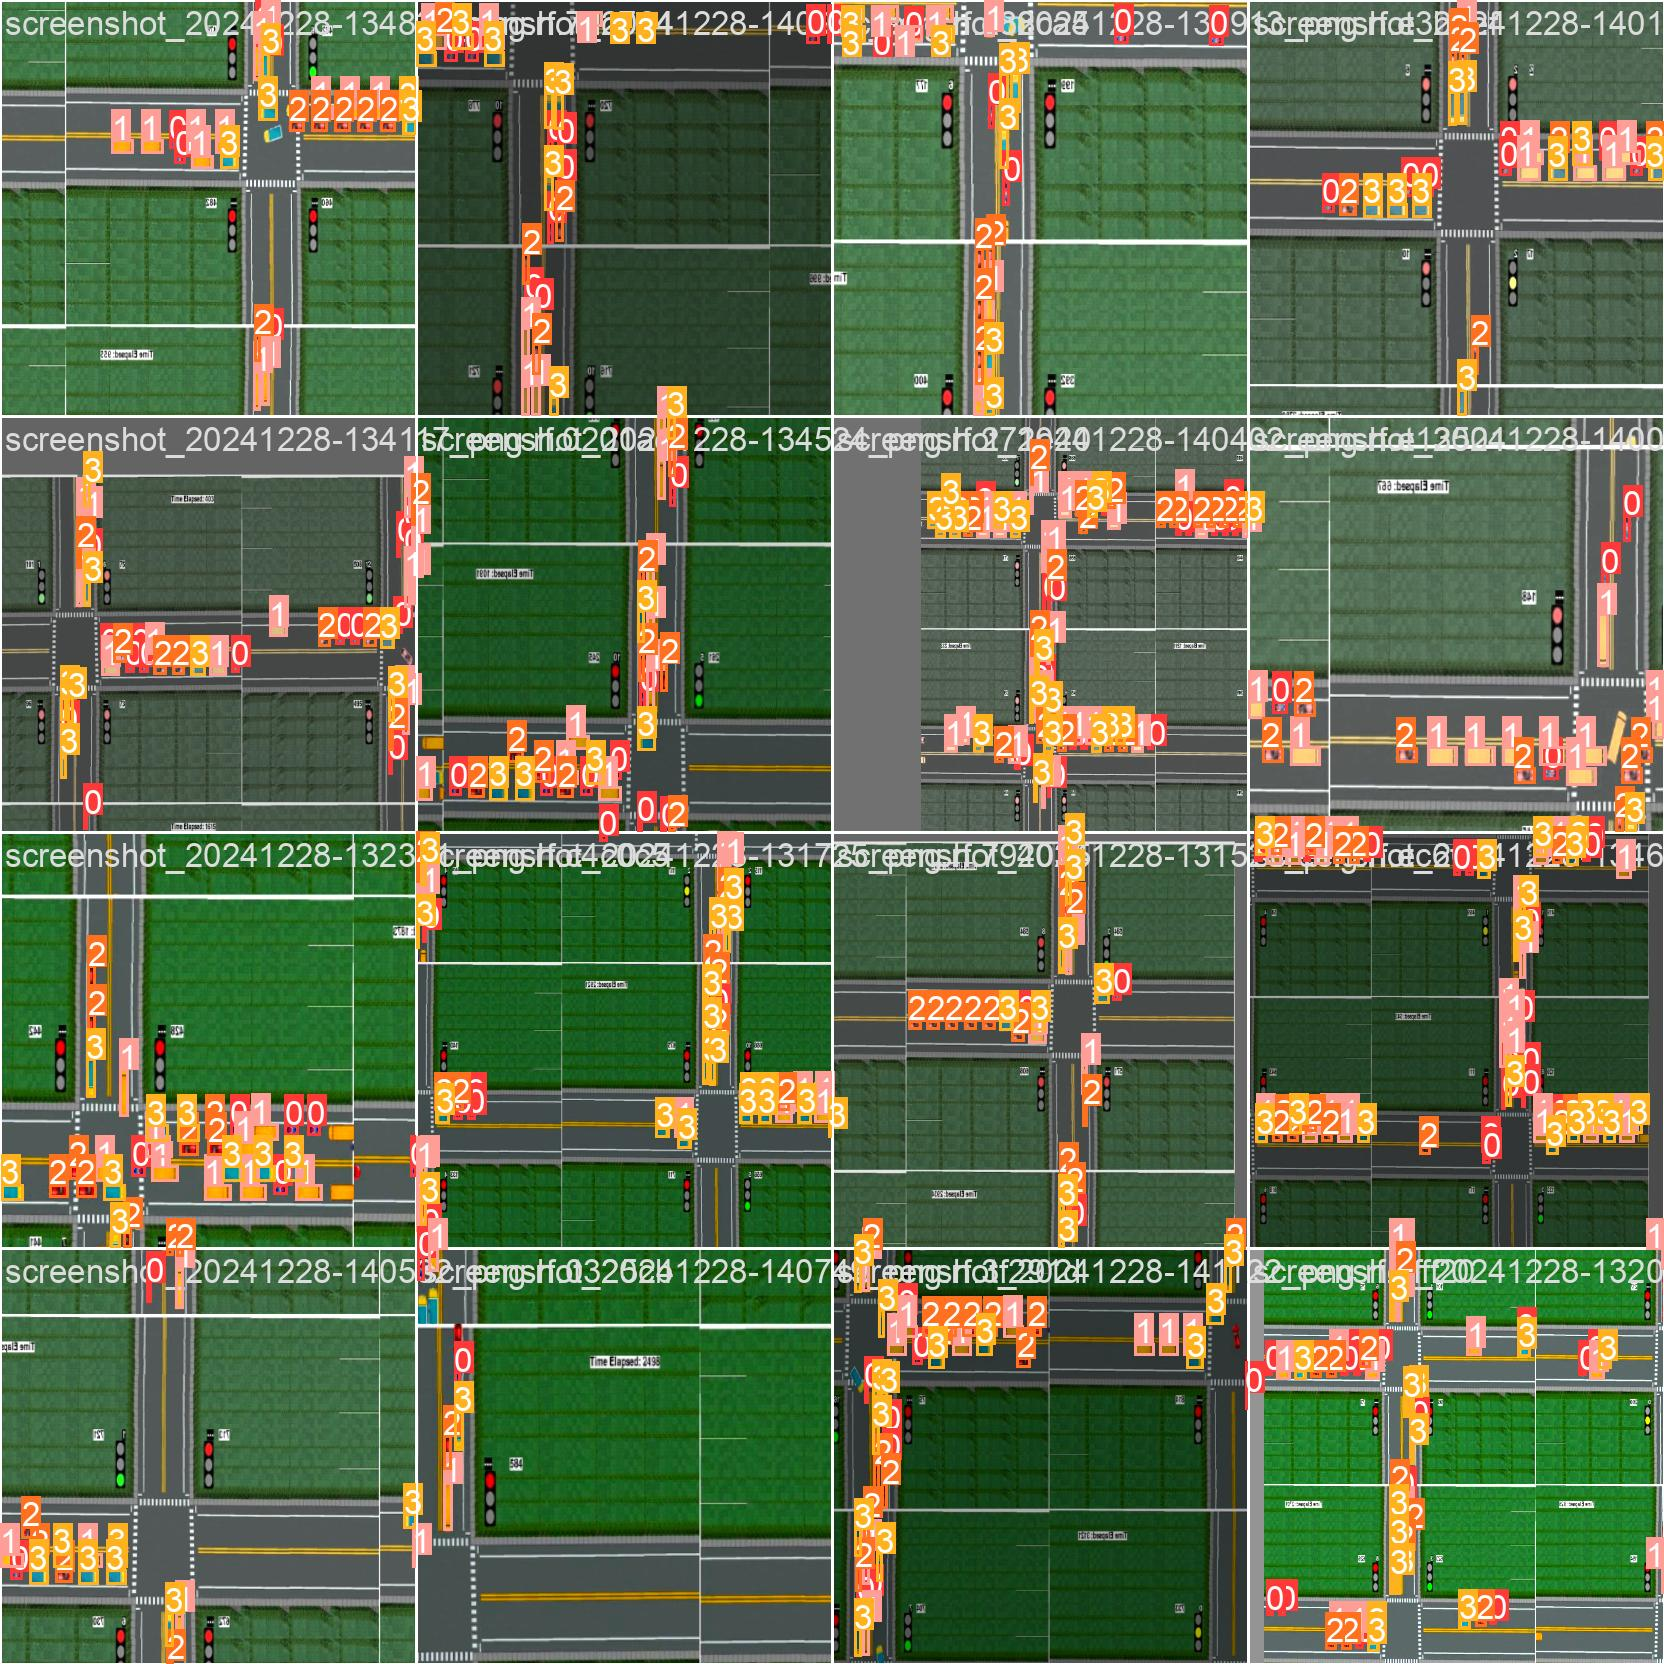

In [32]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [33]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [34]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [36]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/SimTrafficView5K-1/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/SimTrafficView5K-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-390-g0797106a Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7254609 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/500 /content/yolov5/SimTrafficView5K-1/test/images/screenshot_20241228-143012_png.rf.00d96d93f4e3736506df1ede942d06dd.jpg: 416x416 4 0s, 5 1s, 11 2s, 6 3s, 7.7ms
image 2/500 /content/yolov5/SimTrafficView5K-1/test/

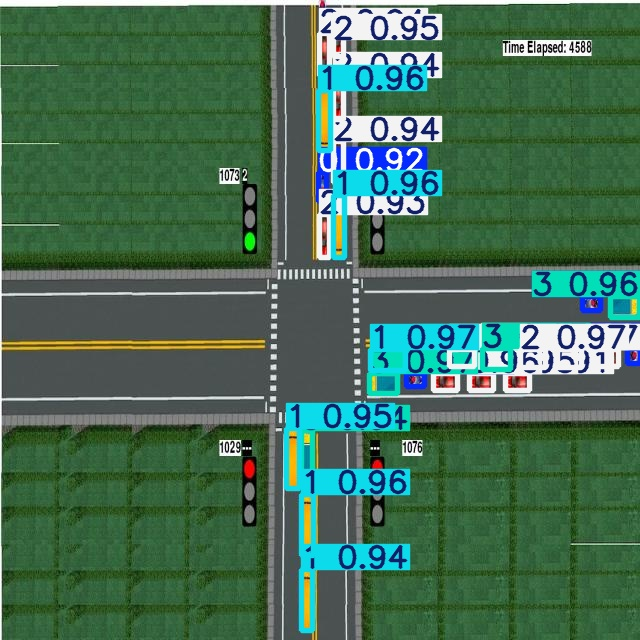

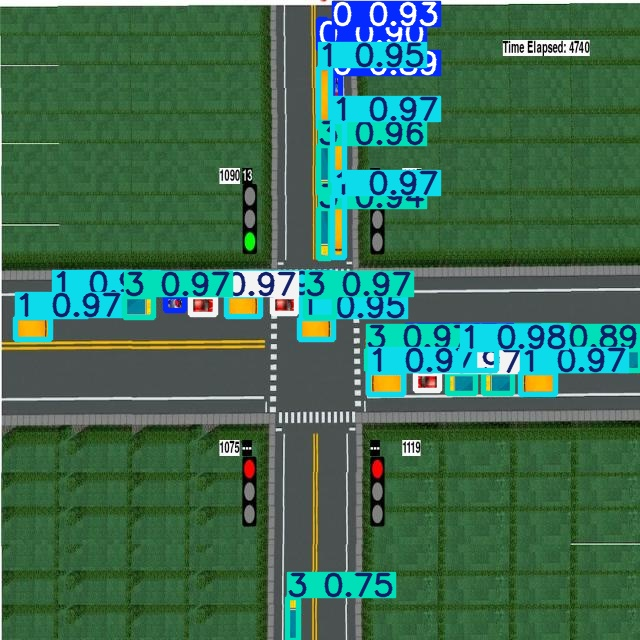

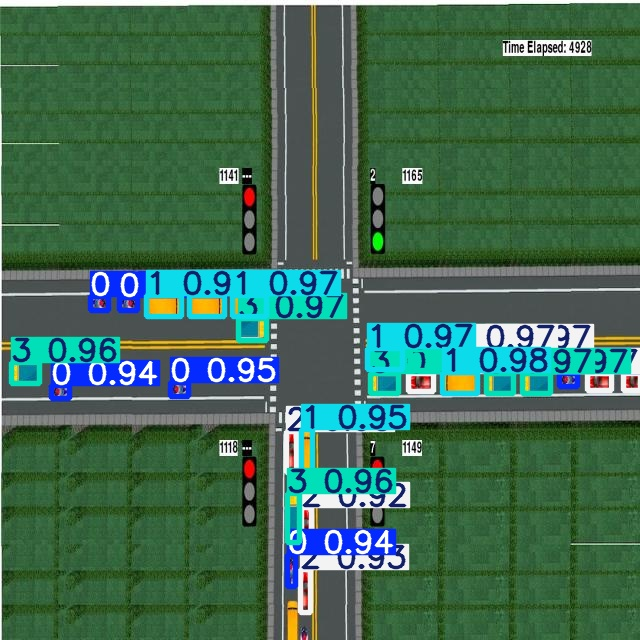

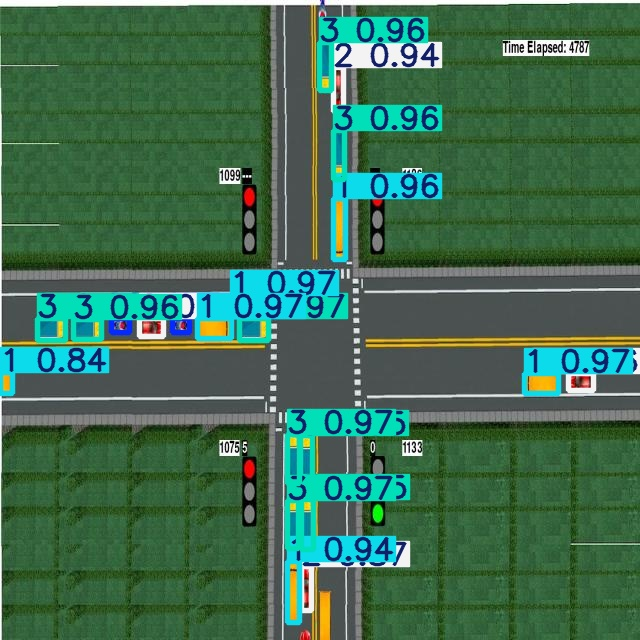

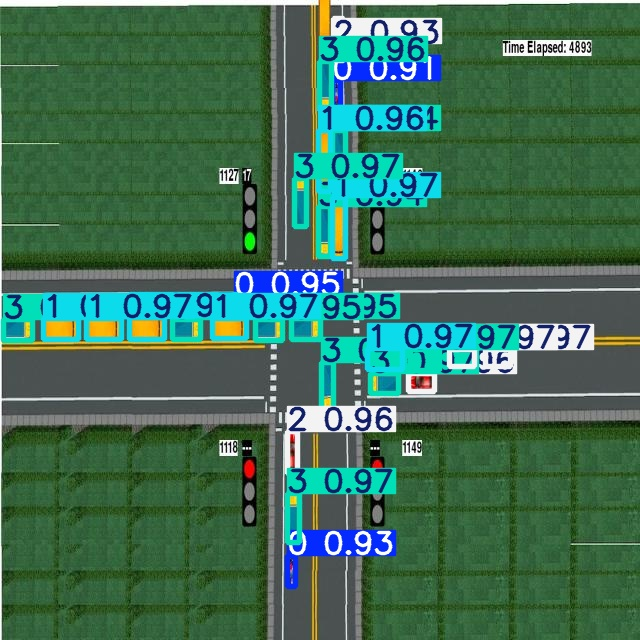

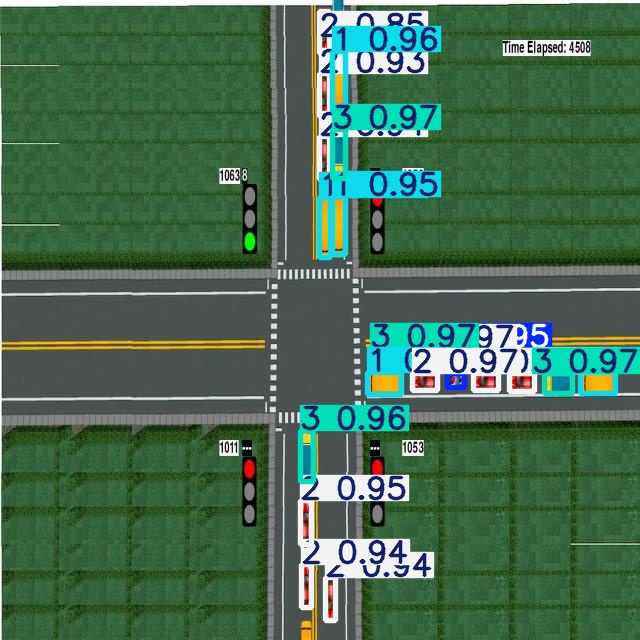

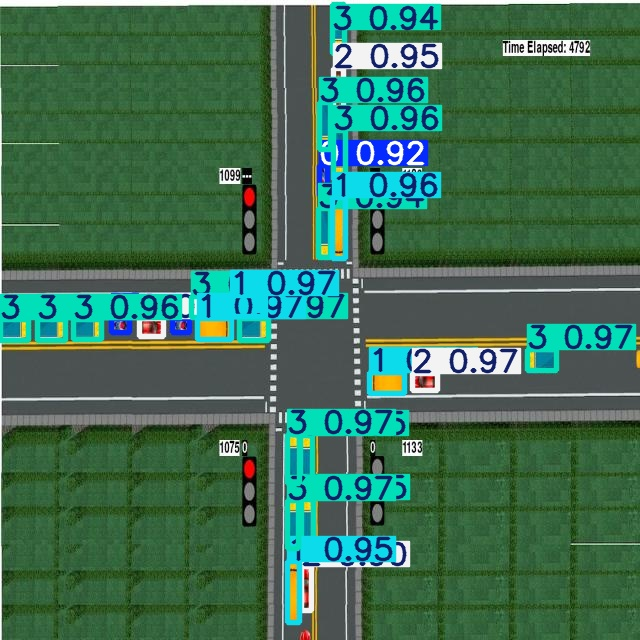

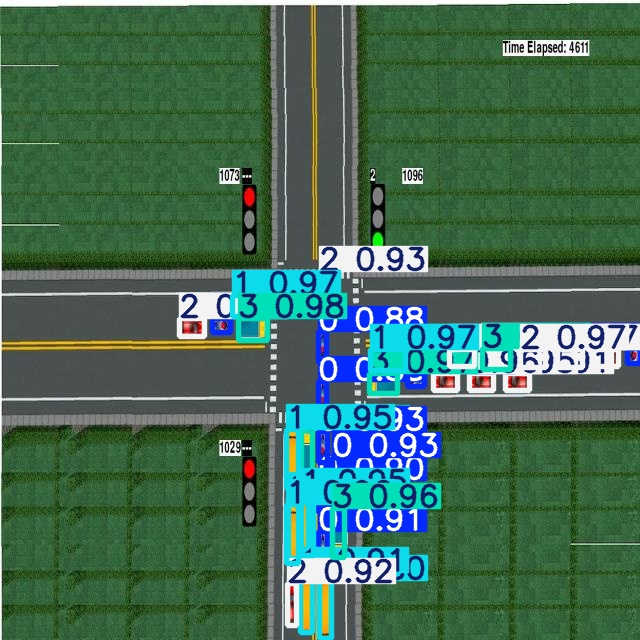

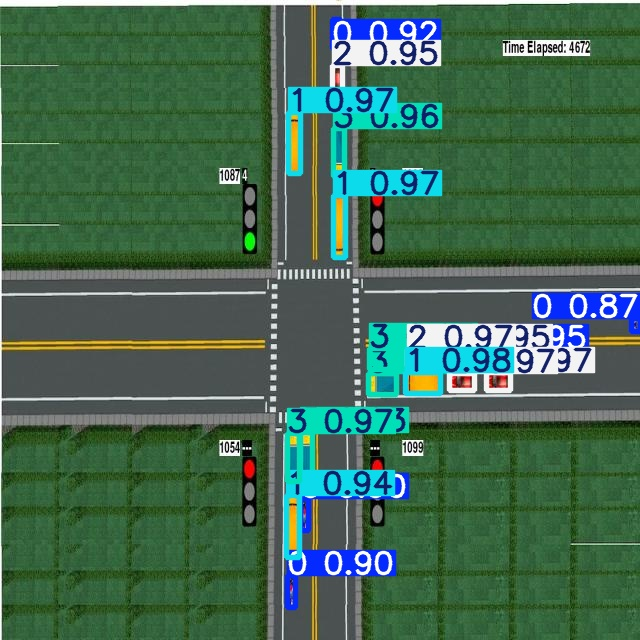

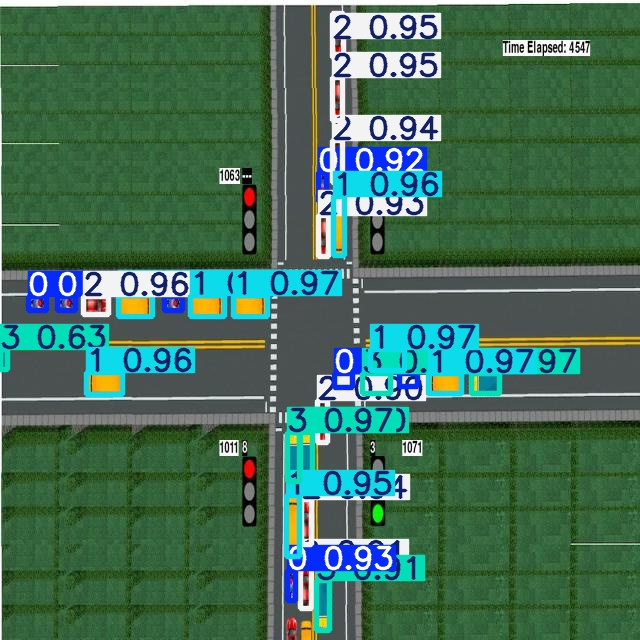

In [41]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

In [42]:
# download model
from google.colab import files
files.download('/content/yolov5/runs/train/yolov5s_results/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>